## Gaussian Markov random field

In this notebook we estimate a simple time-series model using a Gaussian Markov random field model.

We assume that our data consists of noisy observations of a full time-series vector
$$ \mathbf{y} = \mathbf{b} + \boldsymbol\epsilon $$
Assuming independenty normally-distributed errors, the response distribution is a multivariate normal:
$$ \mathbf{y} \sim N(\mathbf{b}, (\tau \mathbf{P}_\tau)^{-1}) $$
For the parameter prior distributions, we assume the following:
$$
\begin{align*} 
\mathbf{b} &\sim N(\boldsymbol\mu, (\lambda \mathbf{P}_\lambda)^{-1}) \\
\lambda &\sim \Gamma( a_\lambda, b_\lambda) \\
\tau &\sim \Gamma( a_\tau, b_\tau) \\
\end{align*}
$$
where $\mathbf{P}_{\lambda}$ is a precision matrix which imposes time-series correlation structure on the parameter vector $\mathbf{b}$.


In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import sparse
import numpy as np
import pandas as pd

from openmcmc.distribution.location_scale import Normal
from openmcmc.distribution.distribution import Gamma
from openmcmc.sampler.sampler import NormalNormal, NormalGamma
from openmcmc import gmrf

from openmcmc.model import Model
from openmcmc.mcmc import MCMC
from openmcmc.parameter import ScaledMatrix

The code below sets up a precision matrix that imposes a correlation structure suitable for a time-series model.

In [2]:
# generate GMRF temporal precision matrix
n_time = 100
TIME = pd.date_range(start="2022-04-01T01:00:00", end="2022-04-01T01:01:00", periods=n_time)
P_lambda = gmrf.precision_temporal(time=TIME)

P_lambda[0, 0] = P_lambda[0, 0] + 0.001  #make full rank

P_lambda.toarray()


array([[ 1.651, -1.65 ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [-1.65 ,  3.3  , -1.65 , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , -1.65 ,  3.3  , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  3.3  , -1.65 ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., -1.65 ,  3.3  , -1.65 ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   , -1.65 ,  1.65 ]])

# Generate Data

The cell below generates a simple time-series signal (from a deterministic model), and adds Gaussian noise to make the observed values.

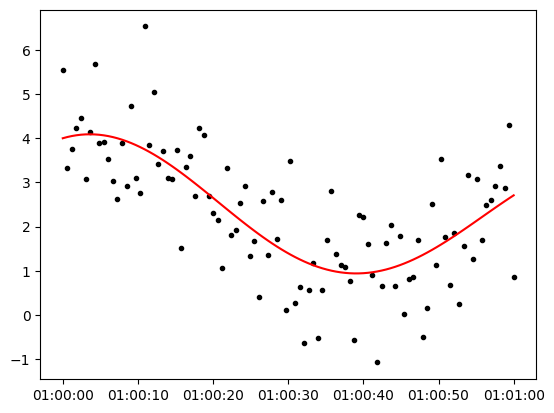

In [3]:
# Generate data
true_tau = 1

t = (TIME-TIME[0]).total_seconds()

b = np.sin(t/20) + 2 * np.cos(t/12)+2

y = b + norm.rvs(loc=0, scale=np.sqrt(1/true_tau), size=n_time)

plt.plot(TIME, y, 'k.')
plt.plot(TIME, b, 'r-')
plt.show()

## Setting up the model


We create the model from distribution blocks available in the openmcmc code. `ScaledMatrix` parameter objects are used for the Normal distribution matrices.

In [4]:
tau_predictor = ScaledMatrix(matrix='P_tau', scalar='tau')
lambda_predictor = ScaledMatrix(matrix='P_lambda', scalar='lambda')

mdl = Model(
    [
        Normal("y", mean="b", precision=tau_predictor),
        Normal("b", mean="mu", precision=lambda_predictor),
        Gamma("lambda", shape="a_lam", rate="b_lam"),
        Gamma("tau", shape="a_tau", rate="b_tau"),
    ]
)

## Setup the initial state

All of the model components are assigned to the initial state below.

In [5]:
initial_state = {
    "y": y,
    "b": y,
    "mu": np.zeros(n_time),
    "lambda": 100,
    "P_lambda": P_lambda,
    "a_lam": 10,
    "b_lam": 1,
    "tau": 1,
    "P_tau": sparse.csc_matrix(np.eye(n_time)),
    "a_tau": 1,
    "b_tau": 1,
}

## Setup the samplers and run MCMC

In this case we estimate 3 parameters:
1. the smoother $b$
2. the level of smoothness $\lambda$
3. the precision $\tau$ of the measurement noise

Because of the use of conjugate normal-gamma pairs of distributions, the full MCMC routine is a Gibbs sampler with exact samplers for the individual conditional distributions.

In [6]:

samplers = [
    NormalNormal("b", mdl),
    NormalGamma("lambda", mdl),
    NormalGamma("tau", mdl),
]

M = MCMC(initial_state, samplers, model=mdl, n_burn=200, n_iter=500)
M.run_mcmc()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:08<00:00, 78.30it/s]


The results of the MCMC are plotted below.

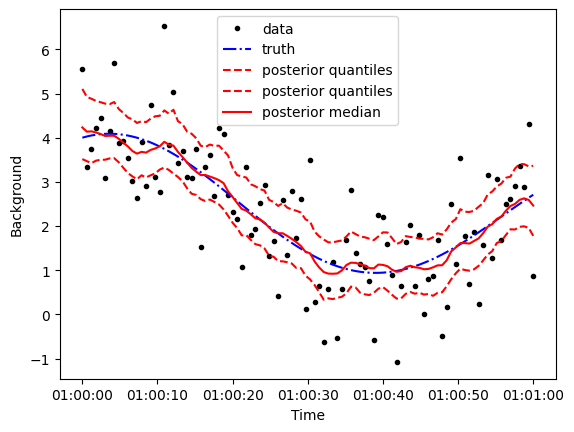

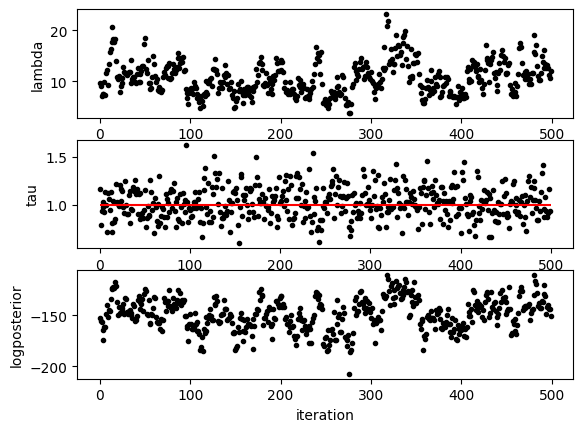

In [7]:
qb = np.quantile(M.store["b"], [0.05,0.5,0.975], axis=1)

plt.figure()
plt.plot(TIME, y, ".k", label="data")
plt.plot(TIME, b, "-.b", label="truth")
plt.plot(TIME, qb[[0,2],:].T, "--r", label="posterior quantiles")
plt.plot(TIME, qb[1,:], "-r", label="posterior median")
plt.ylabel("Background")
plt.xlabel("Time")
plt.legend()

plt.figure()
plt.subplot(3,1,1)
plt.plot(M.store['lambda'].flatten(),'k.')
plt.xlabel('iteration')
plt.ylabel('lambda')

plt.subplot(3,1,2)
plt.plot(M.store['tau'].flatten(),'k.')
plt.hlines(true_tau,0, M.n_iter,'r')
plt.xlabel('iteration')
plt.ylabel('tau')

plt.subplot(3,1,3)
plt.plot(M.store['log_post'],'k.')
plt.xlabel('iteration')
plt.ylabel('logposterior')
plt.show()